In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar
import xarray as xr

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

## Tidy data

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

## Dot plot

In [5]:
cell_tidy_data = cell_tidy_data[cell_tidy_data['MajorType'] == 'MSN-D2']
cell_tidy_data = cell_tidy_data[cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

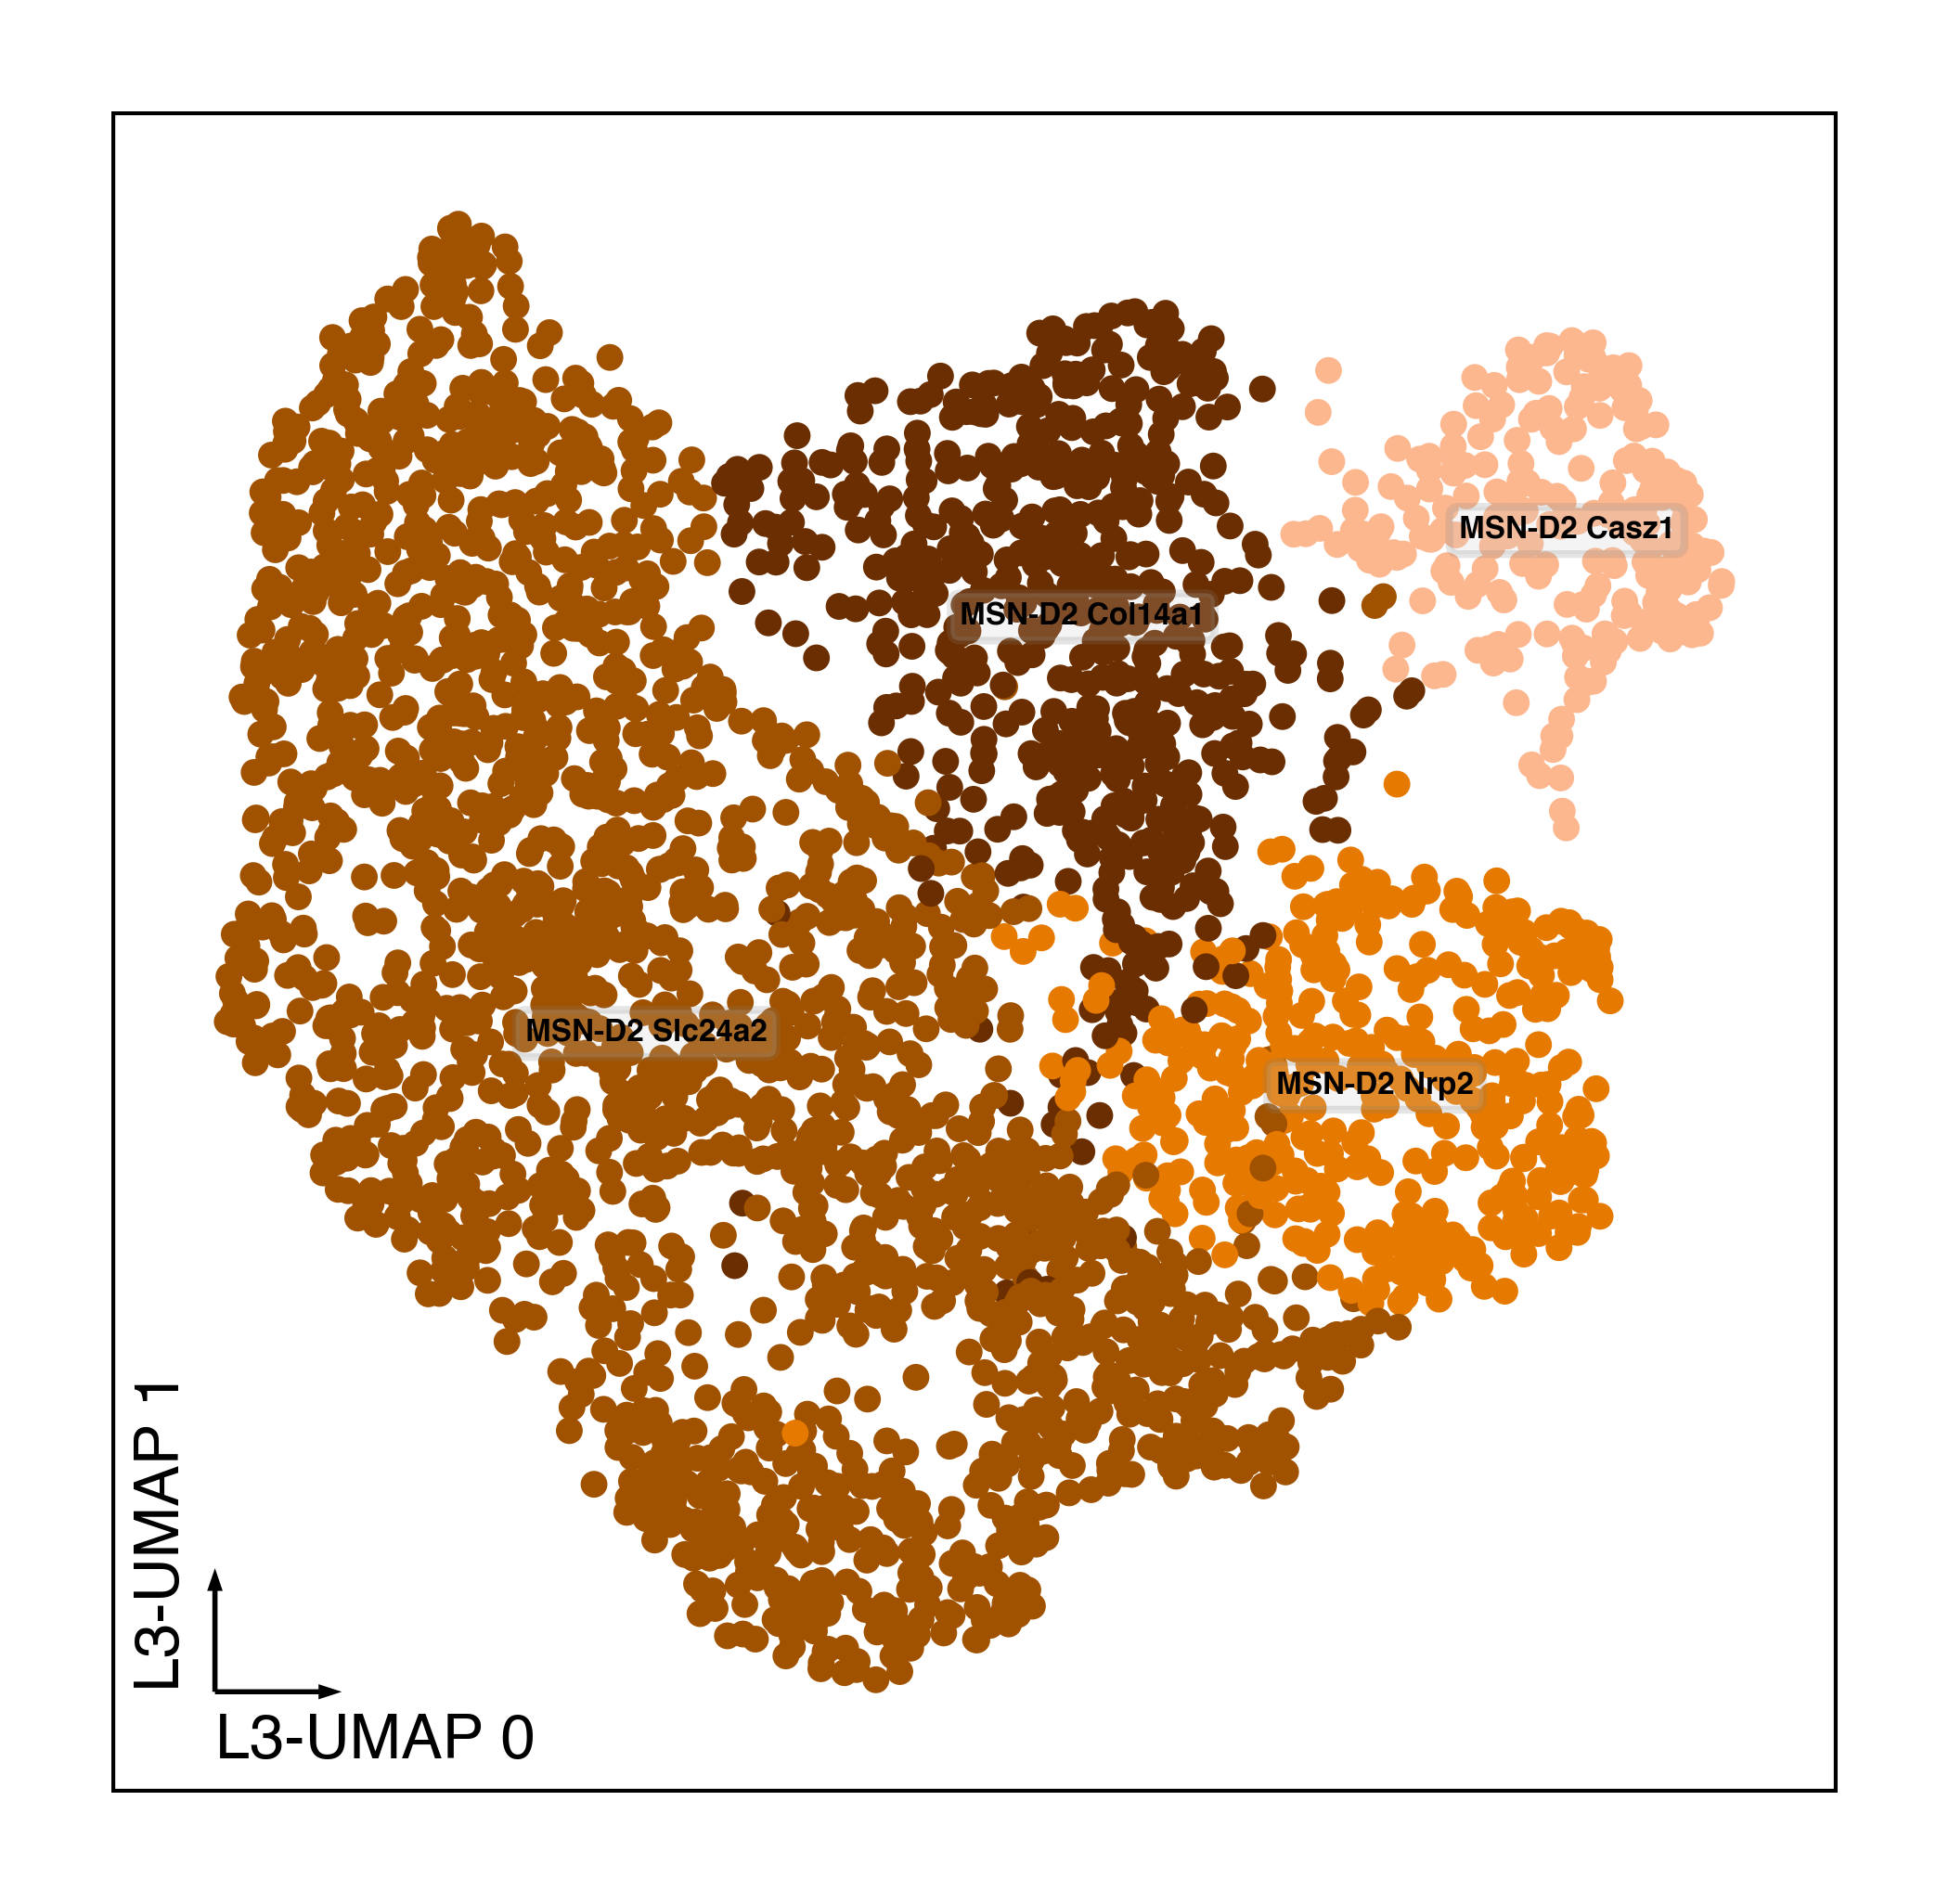

In [6]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-umap',
                    hue='SubType',
                    palette=sub_type_palette,
                    s=3,
                    max_points=None,
                    text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

add_ax_box(ax, linewidth=0.5)
pass

In [7]:
cell_tidy_data['SubType'].unique()

array(['MSN-D2 Slc24a2', 'MSN-D2 Col14a1', 'MSN-D2 Nrp2', 'MSN-D2 Casz1'],
      dtype=object)

In [8]:
region_to_name = cell_tidy_data.set_index('Region')['RegionName'].to_dict()
region_palette = {region_to_name[k]:v for k, v in region_palette.items() if k in region_to_name}

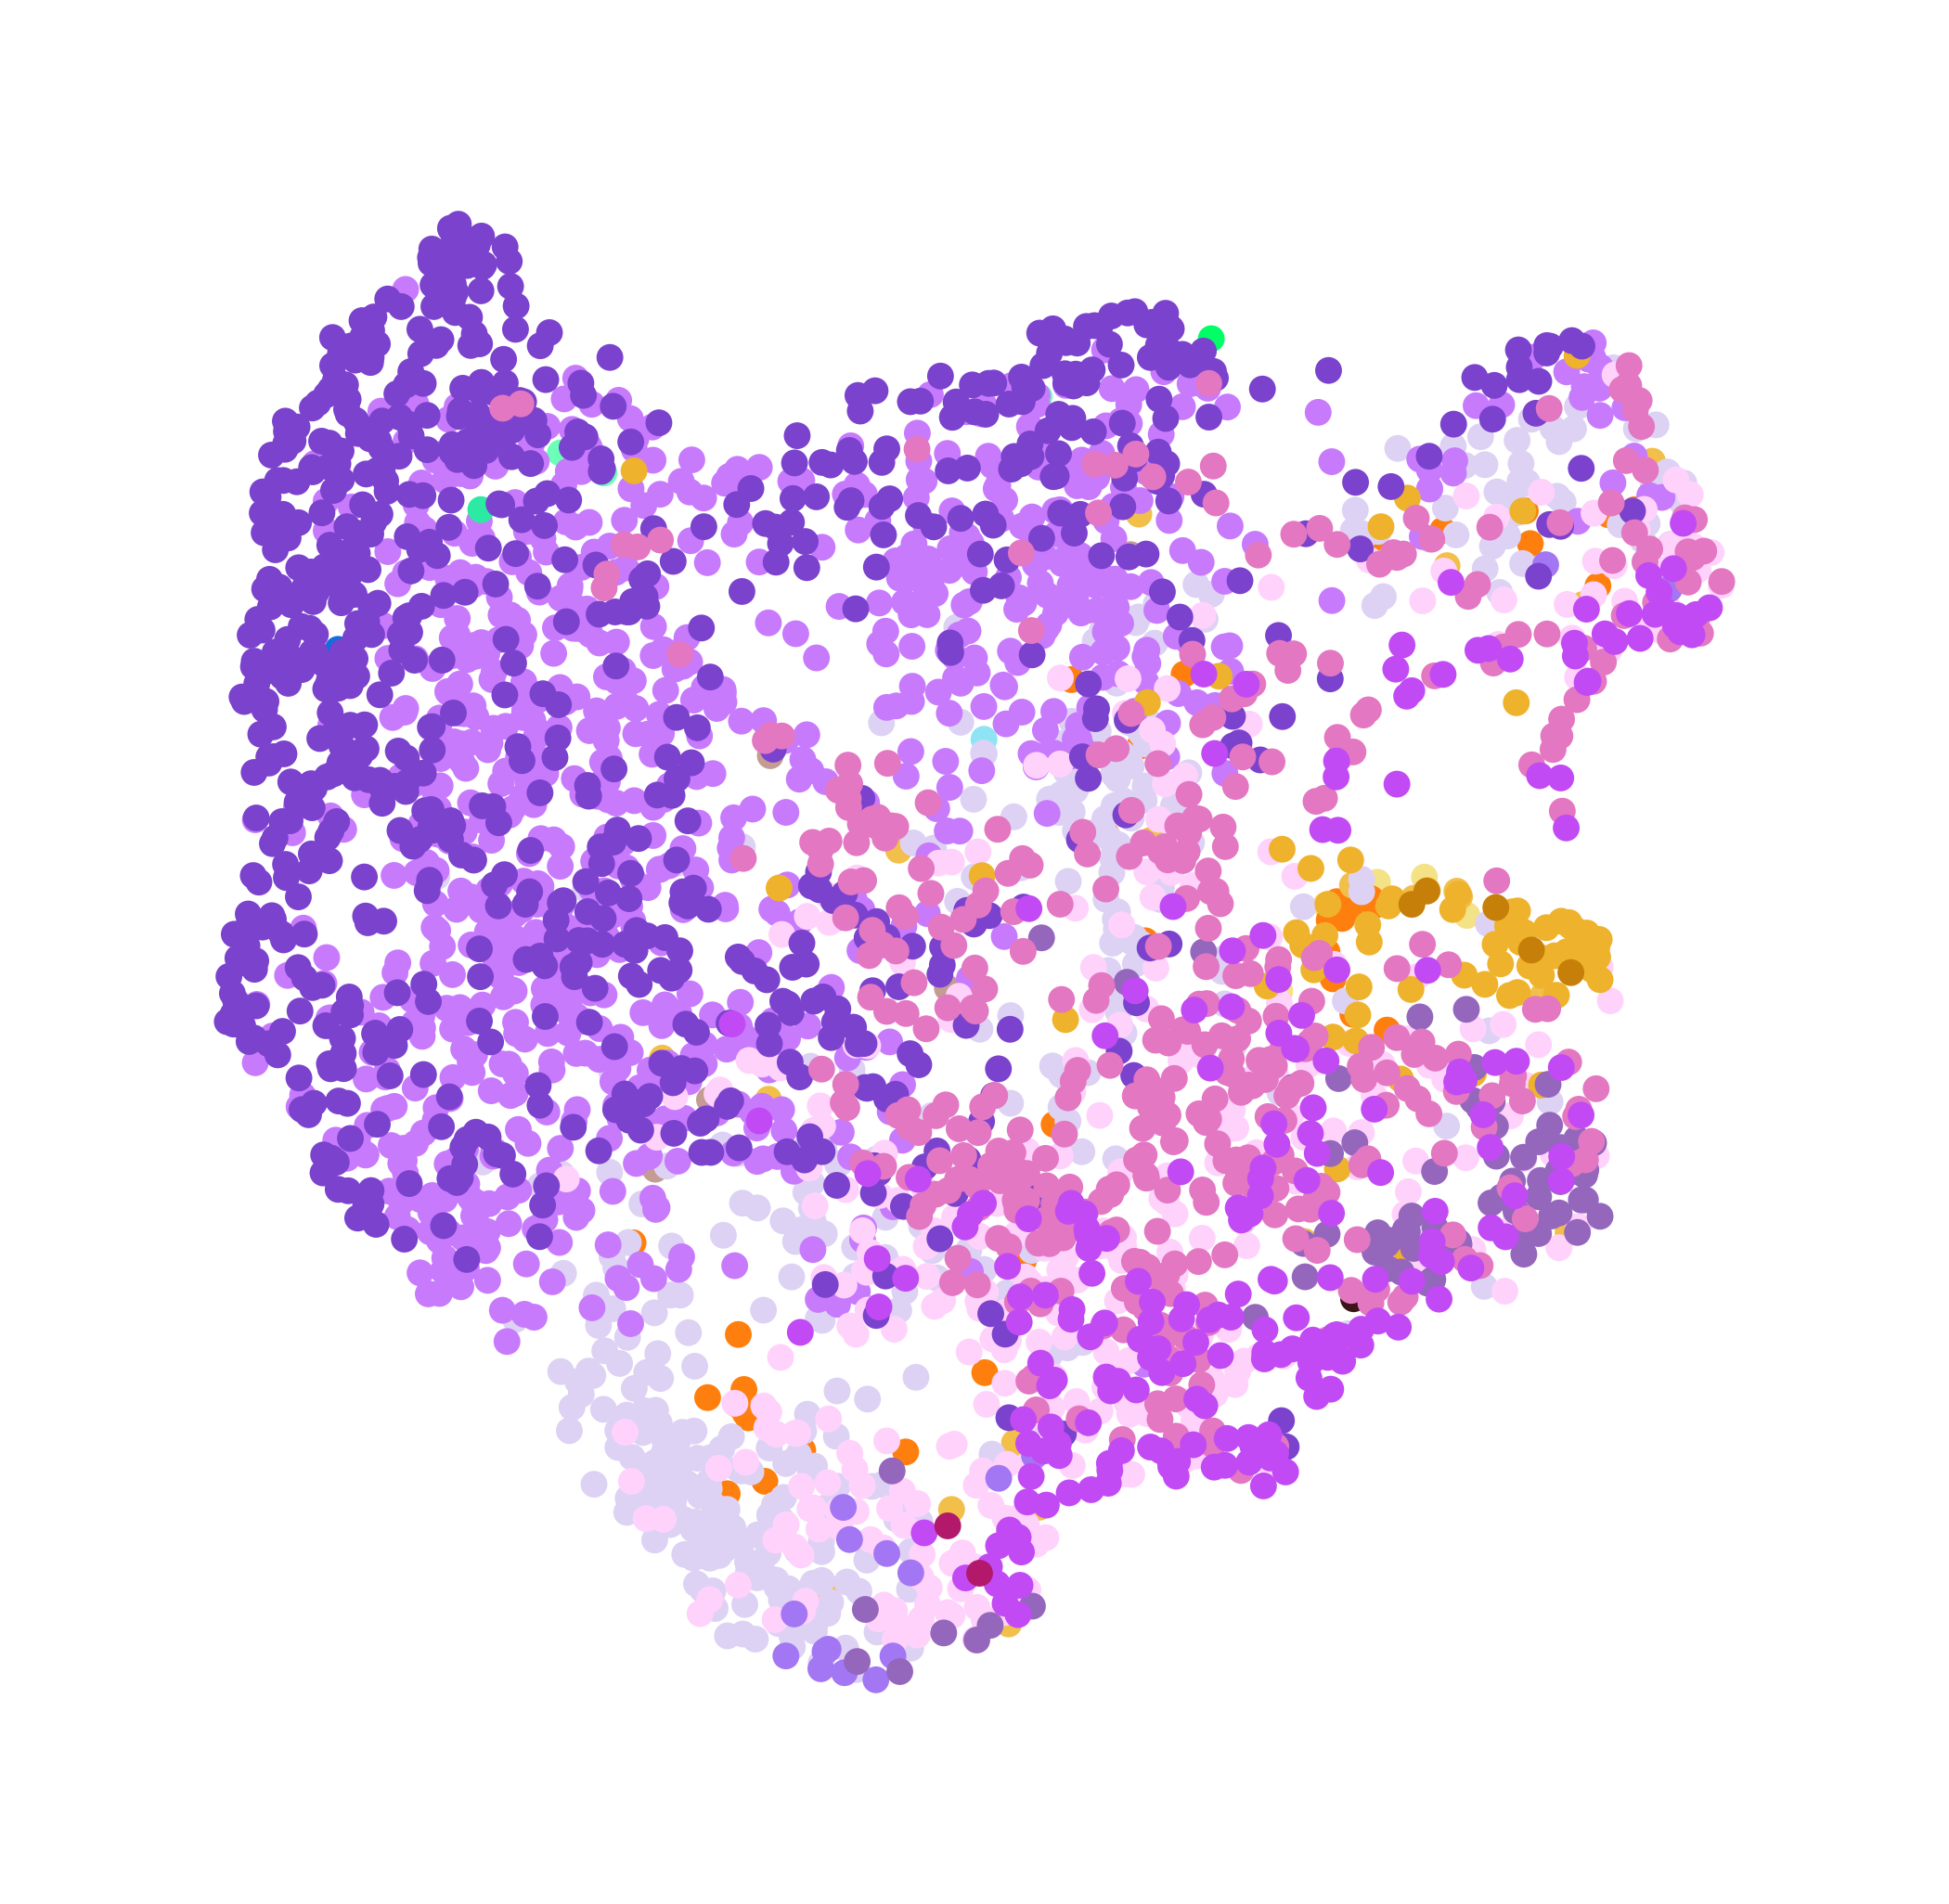

In [9]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-umap',
                    hue='RegionName', palette=region_palette,
                    s=3,
                    axis_format=None,
                    max_points=None,
                    #text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

#add_ax_box(ax, linewidth=0.5)
fig.savefig('UMAP-MSN-D2.color_by_dissection_region.scatter_part.png')
pass

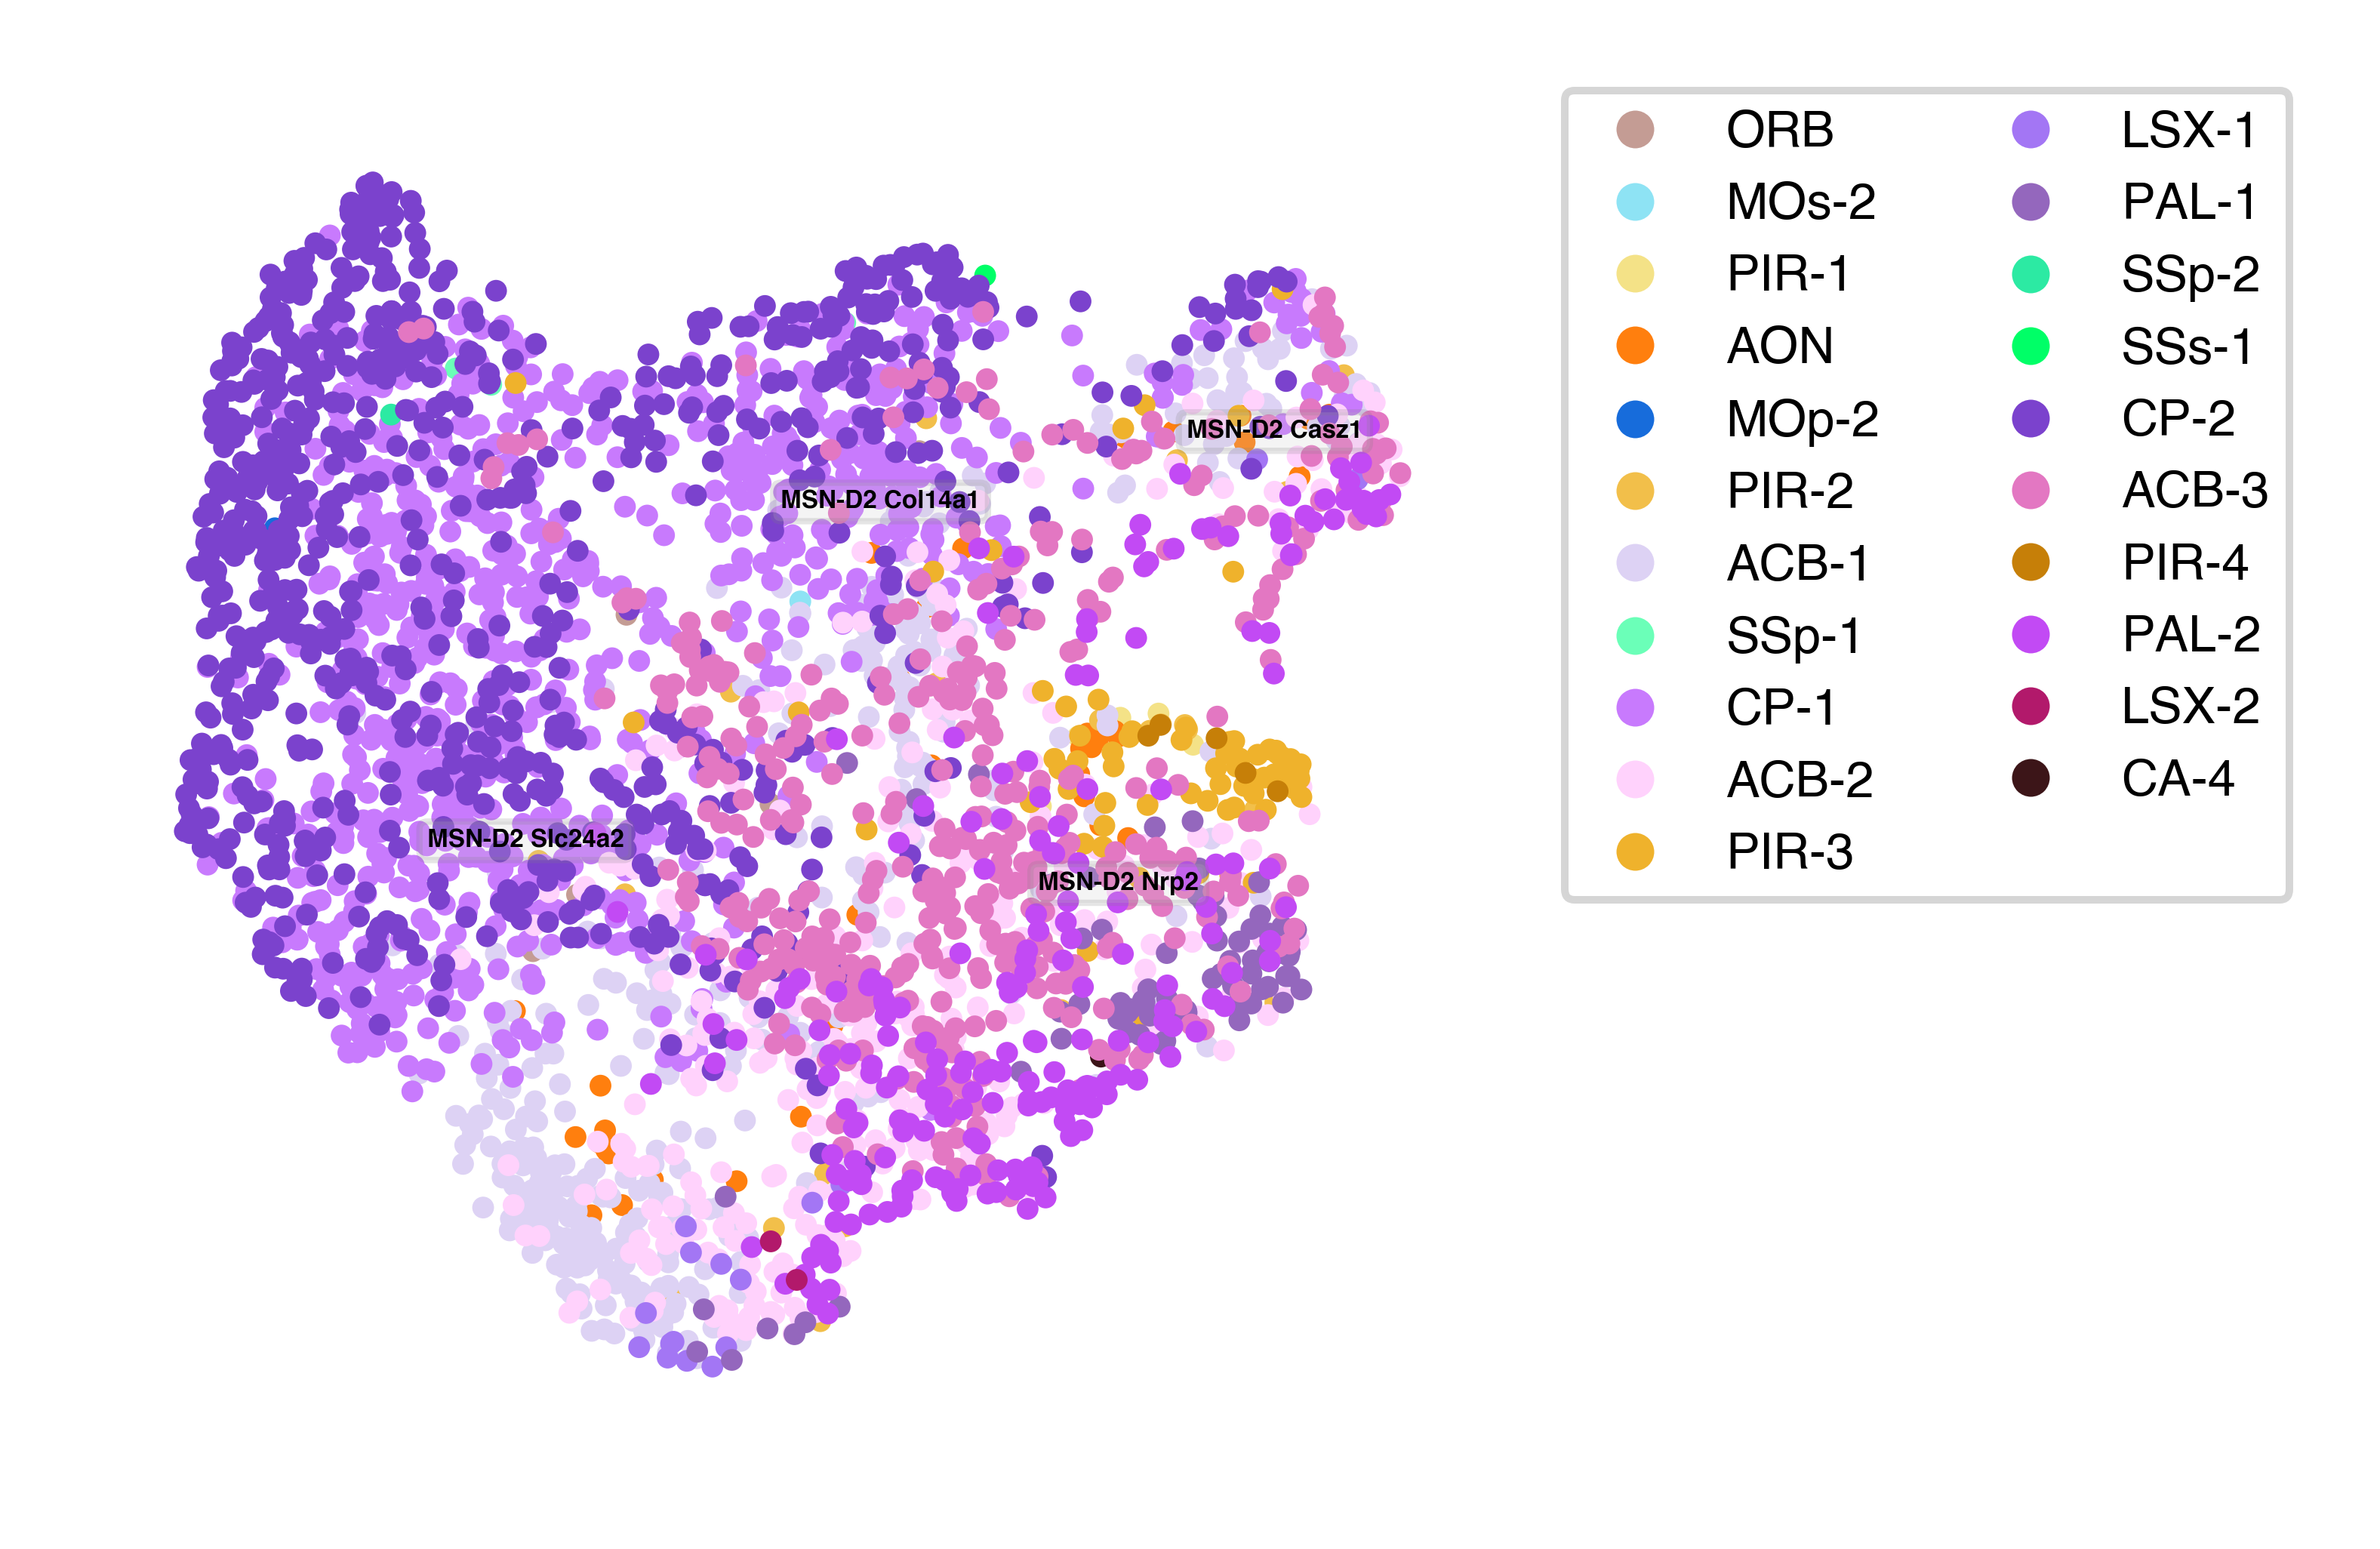

In [10]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-umap',
                    hue='RegionName', palette=region_palette,
                    s=3,
                    axis_format=None,
                    max_points=None,
                    text_anno='SubType', 
                    show_legend=True,
                    text_anno_kws=dict(fontsize=2))

#add_ax_box(ax, linewidth=0.5)
#ax.collections[0].remove()
#fig.savefig('UMAP-MSN-D2.color_by_dissection_region.legend.pdf')
pass

In [18]:
count = cell_tidy_data.groupby(
    'SubType')['RegionName'].value_counts().unstack()[[
        'ACB-1', 'ACB-2', 'ACB-3', 'CP-1', 'CP-2', 'PAL-2'
    ]].fillna(0)

other_count = cell_tidy_data.groupby(
    'SubType')['RegionName'].value_counts().unstack()

other_count = other_count.loc[:, ~other_count.columns.isin(['ACB-1', 'ACB-2', 'ACB-3', 'CP-1', 'CP-2', 'PAL-2'])].sum(axis=1)
count['Other'] = other_count

rate = count / count.sum(axis=1)[:, None]

In [29]:
rate.name = 'rate'
data = rate.unstack().reset_index()

region_order = ['Other', 'ACB-1', 'ACB-2', 'ACB-3', 'PAL-2', 'CP-1', 'CP-2']
cluster_order = ['MSN-D2 Nrp2', 'MSN-D2 Casz1', 'MSN-D2 Col14a1', 'MSN-D2 Slc24a2'][::-1]

data['x'] = data['RegionName'].apply(lambda i: region_order.index(i))
data['y'] = data['SubType'].apply(lambda i: cluster_order.index(i))
region_palette['Other'] = '#888888'

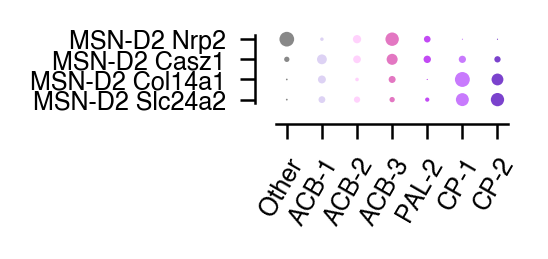

In [30]:
fig, ax = plt.subplots(figsize=(1, 0.3), dpi=300)
sns.scatterplot(data=data,
                ax=ax,
                x='x',
                y='y',
                hue='RegionName',
                palette=region_palette,
                size=0,
                sizes=(0, 50),
                size_norm=(0, 1),
                legend=None,
                clip_on=False)

ax.set(xticks=range(len(region_order)),
       xticklabels=region_order,
       yticks=range(len(cluster_order)),
       yticklabels=cluster_order,
       xlabel='', ylabel='')

sns.despine(ax=ax, offset=5)
[
    t.set(rotation=60, rotation_mode='anchor', ha='right')
    for t in ax.xaxis.get_ticklabels()
]

fig.savefig('CellPortion.D2.dotplot.pdf', bbox_inches='tight')

In [31]:
cell_tidy_data['RegionName'].value_counts()

CP-1     871
CP-2     824
ACB-3    435
ACB-1    390
ACB-2    341
PAL-2    224
PAL-1     77
PIR-3     70
AON       40
PIR-2     25
LSX-1     17
PIR-1      6
ORB        5
PIR-4      5
SSp-1      3
LSX-2      2
MOs-2      1
MOp-2      1
SSs-1      1
CA-4       1
SSp-2      1
Name: RegionName, dtype: int64

In [31]:
cell_tidy_data[cell_tidy_data['MajorType'] == 'MSN-D1'].groupby('SubType')['SubRegion'].value_counts()

SubType         SubRegion
MSN-D1 Hrh1     CP           1288
                ACB            50
                PIR             3
                ORB             2
                SSp             2
                SSs             2
                ACA             1
                MOs             1
MSN-D1 Khdrbs3  CP            497
                ACB            35
                PIR             3
                SSs             2
                AI              1
                AON             1
                ORB             1
                PAL             1
MSN-D1 Ntn1     ACB           265
                AON            22
                LSX            20
                PAL            10
                PIR             3
                CP              2
MSN-D1 Outlier  CP              1
MSN-D1 Plxnc1   ACB           532
                CP            253
                PAL           110
                PIR            21
                AON             9
                ORB   

In [32]:
cell_tidy_data[cell_tidy_data['MajorType'] == 'MSN-D1']['SubType'].value_counts()

MSN-D1 Hrh1       1349
MSN-D1 Plxnc1      926
MSN-D1 Khdrbs3     541
MSN-D1 Ntn1        322
MSN-D1 Outlier       1
Name: SubType, dtype: int64

In [37]:
(265+22+20+10+3+532+110+21+9) / (322+926)

0.7948717948717948

In [34]:
cell_tidy_data['MajorType'].value_counts()

MSN-D2    3340
Name: MajorType, dtype: int64